Michael Buchwitz, 20-Nov-2024

# How to access, read and use satellite XCO2 and XCH4 Level 3 data products

This is a Jupyter Notebook (JN) illustrating how to access, read and use Greenhouse Gas (GHG) atmospheric carbon dioxide (CO2) and methane (CH4) data products as generated in the framework of the Copernicus Climate Change Service (C3S).

The C3S GHG data products used here are retrieved from satellite radiance measurement using dedicated retrieval algorithms. Most of these algorithms have been developed in the past within the Climate Change Initiative (CCI) of the European Space Agency (ESA). These algorithms are now used to operationally generate the corresponding data products within the European Union (EU) C3S project. The data products are freely available for all interested users from the Copernicus Climate Data Store (CDS,
https://cds.climate.copernicus.eu/).

Several satellite-derived Essential Climate Variable (ECV) atmospheric data products are generated for GHGs (CO2 and CH4), aerosols and ozone. This JN focusses on GHG Level 3 (L3) products. The other products are covered by separate JNs. The GHG L3 products are available at a spatial resolution of 5 deg latitude times 5 deg longitude and monthly time resolution. In contrast, Level 2 (L2) products contain retrieved parameters for individual satellite ground pixels (footprints). How to use L2 GHG products is described in a separate JN.

The GHG L3 products contain column-averaged dry-air mole fractions of CO2 and CH4, denoted XCO2 (in ppm) and XCH4 (in ppb). They are derived from SCIAMACHY/ENVISAT, GOSAT, GOSAT-2 and OCO-2. The relevant peer-reviewed publication describing the algorithm and an earlier version of the data products is Reuter et al., 2020 (https://amt.copernicus.org/articles/13/789/2020/). The relevant technical documentation and further information is available on the CDS website (https://cds.climate.copernicus.eu/).

The atmospheric concentration of both gases varies in time and in space. This JN focusses on two use cases. 

The first use case is related to temporal variations. Temporal atmospheric concentration variations depend, for example, on latitude. Seasonal variations are, for example, different for the northern hemisphere (NH) and the southern hemisphere (SN), whereas the increasing trend is similar for different latitude bands. This can be investigated by generating and plotting time series for latitude bands. How this can be done is shown in this JN.

The second use case is related to spatial variations. Here it is shown how spatial maps of GHG concentrations and their uncertainty can be generated. Depending on time (month, season) XCO2 maps show large differences of the CO2 concentration in the two hemispheres, i.e., a significant interhemispheric CO2 gradient. This is also observed for XCH4. In each hemisphere the concentration of both gases is quite similar as both gases are long lived and well mixed due to atmospheric transport and diffusion. Nevertheless, strong source regions are sometimes (during certain months) directly visible via locally enhanced concentrations.  This can be seen and investigated by generating monthly XCO2 and XCH4 maps. The monthly maps also show the time dependent spatial coverage of the satellite-derived data products. This is primarily due to the fact that these satellite observations require good solar illumination conditions. The spatial coverage therefore closely follows the sun with better coverage of the summer hemisphere compared to the winter hemisphere. Data gaps are also due to clouds (all data are filtered to avoid cloud contamination), water surfaces (oceans and lakes, etc., are poor reflectors of solar radiation in the short-wave infra-red spectral range except for sun-glint observing conditions) and for other reasons. How these spatial maps can be generated is shown in this JN. 

The L3 XCO2 data product used here has product identifier (ID) XCO2_OBS4MIPS and the L3 XCH4 product ID is XCH4_OBS4MIPS. The code has been tested using version 4.5 of these products, which covers the period from beginning of 2003 to end of 2022.

## How to read and process the satellite data with Python

In the following, Phython 3 code is provided to read and process the satellite data. 

It is assumed that Python and Jupyter Notebook (JN) is installed on your computer, e.g., using the Anaconda distribution (https://www.anaconda.com/products/distribution).

## Imports

First we have to import some modules:

In [5]:
# Import libraries needed for the Jupyter notebook

# Note that lines starting with "#" are comment lines

# Libraries for working with data, especially multidimensional arrays
import numpy as np
import pandas as pd
import xarray as xr

# Library to work with zip-archives, operating system (OS) functions and pattern expansion
import zipfile
import os
from pathlib import Path

# Libraries for plotting and visualising data
import matplotlib.pyplot as plt
import matplotlib as mplt
#import matplotlib.dates as md
import cartopy.crs as ccrs
import datetime

# Libraries for style parameters
from pylab import rcParams
import seaborn as sns

# Disable warnings for data download via API
import urllib3
urllib3.disable_warnings()

print('* ... finished importing modules')

* ... finished importing modules


## How to access satellite data products

The C3S GHG data products and their documentation are available from the CDS website. 

CO2 data and documents are available from https://cds.climate.copernicus.eu/datasets/satellite-carbon-dioxide?tab=overview.

CH4 data and documents are available from https://cds.climate.copernicus.eu/datasets/satellite-methane?tab=overview.

Each satellite-derived CO2 or CH4 data product as generated in C3S and made available via the CDS has a unique product ID. The product IDs of the Level 3 products used here are XCO2_OBS4MIPS and XCH4_OBS4MIPS. Each products consists of a single NetCDF file in Obs4MIPs format (https://esgf-node.llnl.gov/projects/obs4mips/). These products have been generated by merging data products from different satellite sensors. On the CDS website these products can be selected and downloaded by selecting "MERGED and OBS4MIPS" for item "Sensor and algorithm" as described in details in the following section. 

### Data access via CDS API (cdsapi)

The C3S data products can be downloaded them from the Copernicus Climate Data Store (CDS) using the cdsapi, i.e., the CDS Application Programming Interface (API). How to use the cdsapi is described here:

First, goto the CDS website: 
    https://cds.climate.copernicus.eu/ 
    
Login (if not done already, please register using "Create new account").

To use the cdsapi you need to set two variables, URL and KEY:

In [6]:
# Specify the CDS path for data access and your personal access key:

URL='https://cds.climate.copernicus.eu/api'
# Replace the string by your personal key (see below):
KEY='XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'

print('* URL: ', URL)
print('* KEY: ', KEY)

* URL:  https://cds.climate.copernicus.eu/api
* KEY:  a8764fcc-d86b-4791-81c7-66c40885a25a


KEY 'XXX...XXX' is only a placeholder and needs to be replaced by your personal KEY.

To get your KEY, please login to the CDS website (see above) and then visit https://cds.climate.copernicus.eu/how-to-api.
    
Your personal KEY will appear on the screen. 
Use that KEY to replace the placeholder key 'XXX...XXX' shown above.

### How to select and download a specific data product

In the following we explain how to obtain XCO2_OBS4MIPS v4.5 data product files.

The same method can be used to get the corresponding methane product XCH4_OBS4MIPS or another version of these Level 3 products.

Visit the CDS website https://cds.climate.copernicus.eu/ and search for "CO2" in the search field.
    
Then click on: 
- Carbon dioxide data from 2002 to present derived from satellite observations

Click on the "Download" tab.

Select the desired product by choosing in the "Download" tab:
- Processing level: Level 3
- Variable: Column-average dry-air mole fraction of atmospheric Carbon Dioxide (XCO2) and related variables
- Sensor and algorithm: MERGED and OBS4MIPS
- Version: 4.5

Then click on:
- Show API request code

The following Python code will appear on the screen:

import cdsapi

dataset = "satellite-carbon-dioxide"

request = {

    "processing_level": ["level_3"],
    
    "variable": "xco2",
    
    "sensor_and_algorithm": "merged_obs4mips",
    
    "version": ["4_5"]
    
}

client = cdsapi.Client()

client.retrieve(dataset, request).download()

This code is used below to access the data.

## Other preparatory work including data directory

In [21]:
# Specify local data directory for the downloads:

#data_directory = "./data_dir_tmp/"   # Test only
data_directory = "data_dir"

DATADIR = Path(data_directory)

if not os.path.exists(DATADIR):
   print('* Generating: ', DATADIR) 
   os.mkdir(DATADIR)
else:
   print('* sub-directory exists: ', DATADIR)

* Generating:  data_dir


## Setting default plot style parameters

In [22]:
# The following style parameters will be used for all plots in this use case.
rcParams['figure.figsize'] = [15,5]
rcParams['figure.dpi'] = 350
#rcParams['font.family'] = 'serif'
rcParams['font.family'] = 'Arial'
#rcParams['font.serif'] = mplt.rcParamsDefault['font.serif']
#rcParams['mathtext.rm'] = 'serif:light'
#rcParams['mathtext.it'] = 'serif:italic'
#rcParams['mathtext.bf'] = 'serif:bold'
rcParams['mathtext.default'] = 'regular'
plt.rc('font', size=17)          # controls default text sizes
plt.rc('axes', titlesize=17)     # fontsize of the axes title
plt.rc('axes', labelsize=17)     # fontsize of the x and y labelsize
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.rc('legend', fontsize=10)    # fontsize of the legend
plt.rc('figure', titlesize=18)   # fontsize of the figure title

projection = ccrs.PlateCarree()
mplt.rc('xtick', labelsize=9)
mplt.rc('ytick', labelsize=9)

print('* ... finished setting default plot style parameters')

* ... finished setting default plot style parameters


## Product selection: XCO2 or XCH4 Level 3 OBS4MIPS product

Select the desired product by activating either the line with XCO2 or the line with XCH4. Here we have selected XCH4:

In [11]:
# Select one main product (by commenting in/out):
#product_name = 'XCO2'
product_name = 'XCH4' 

product_id = product_name+'_OBS4MIPS'

#Select product version (by commenting in / out):
#product_version = 'v4.4'; product_version_str2 = '4_4'; product_period = '200301_202112'
product_version = 'v4.5'; product_version_str2 = '4_5'; product_period = '200301_202212'

print('* Selected Level 3 product:')
print('* product_id: ', product_id)
print('* product_version: ', product_version)

* Selected Level 3 product:
* product_id:  XCH4_OBS4MIPS
* product_version:  v4.5


## Product specific settings

Here some variables are set depending on the selected product:

In [23]:
# Define some product specific variables:
if product_name == 'XCO2':
   wanted_variable      = 'xco2'        # main variable
   wanted_variable_unc  = 'xco2_stderr' # uncertainty of main variable
   unit_conv         = 1e6              # unit conversion factor from mole/mole to ppm
   unit              = '[ppm]'          # desired unit
if product_name == 'XCH4':              
   wanted_variable      = 'xch4'        # main variable
   wanted_variable_unc  = 'xch4_stderr' # uncertainty of main variable
   unit_conv         = 1e9              # unit conversion factor from mole/mole to ppb
   unit              = '[ppb]'          # desired unit
    
print('* wanted_variable: ', wanted_variable)

* wanted_variable:  xch4


## Data download via cdsapi

In [24]:
# Have the data already been downloaded (please select by commenting in/out)?:
product_already_downloaded = 'no'     # Default
#product_already_downloaded = 'yes'   # Use this if data already downloaded

if product_already_downloaded == 'no':

   print('* downloading product ...')

   # Code obtained via "Show API request code" (see above):

   if product_name == 'XCO2':
      # Copy code obtained from "Show API request code":
      import cdsapi
      dataset = "satellite-carbon-dioxide"
      request = {
         "processing_level": ["level_3"],
          "variable": "xco2",
          "sensor_and_algorithm": "merged_obs4mips",
          #"version": ["4_5"]
          "version": [product_version_str2]
      }

   if product_name == 'XCH4':
      # Copy code obtained from "Show API request code":
      import cdsapi
      dataset = "satellite-methane"
      request = {
         "processing_level": ["level_3"],
          "variable": "xch4",
          "sensor_and_algorithm": "merged_obs4mips",
          #"version": ["4_5"]
          "version": [product_version_str2]
      }

   client = cdsapi.Client(url=URL, key=KEY)
   # Generates download.zip file in current directory:
   client.retrieve(dataset, request).download('download.zip')
   
   # Unzip:
   path_to_zip_file        = 'download.zip'
   with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(DATADIR)
    
else:
    print('* The following has been selected: product_already_downloaded: ', product_already_downloaded)
    print('* Therefore, no data download via cdsapi')

* downloading product ...


2024-11-20 13:27:41,326 WARNING [2024-11-19T00:00:00] Issue with underlaying infrastructure is now solved. System should gradually recover. Please check updated status [here](https://status.ecmwf.int/)
2024-11-20 13:27:41,328 INFO [2024-09-28T00:00:00] **Welcome to the New Climate Data Store (CDS)!** This new system is in its early days of full operations and still undergoing enhancements and fine tuning. Some disruptions are to be expected. Your 
[feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is key to improve the user experience on the new CDS for the benefit of everyone. Thank you.
2024-11-20 13:27:41,332 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2024-11-20 13:27:41,334 INFO [2024-09-16T00:00:00] Remember that you need to have an ECMWF account to use the new CDS. **Your old CDS credentials will not work in new CDS!**
2024-11-20 13:27:41,336 WARNING [2024-06-16T00:00:00] CDS 

6f0e7e603125360263563cb72ca73ada.zip:   0%|          | 0.00/57.0M [00:00<?, ?B/s]

## Check if the desired data are available

In [25]:
# If the above cell has been executed for both products, then following two files should be located in sub-directory data_dir:
# 200301_202212-C3S-L3_XCO2-GHG_PRODUCTS-MERGED-MERGED-OBS4MIPS-MERGED-v4.5.nc
# 200301_202212-C3S-L3_XCH4-GHG_PRODUCTS-MERGED-MERGED-OBS4MIPS-MERGED-v4.5.nc

# Check if the desired file exists:
wanted_file_OK = 'no'
wanted_file = product_period+'-C3S-L3_'+product_name+'-GHG_PRODUCTS-MERGED-MERGED-OBS4MIPS-MERGED-'+product_version+'.nc'
wanted_path_file = DATADIR/wanted_file
print('* wanted product file: ', wanted_path_file)
if (os.path.exists(wanted_path_file) == True):
   print('* ... file exists')
   wanted_file_OK = 'yes'
else:
   print('* ERROR: File does not exist !?')

* wanted product file:  data_dir\200301_202212-C3S-L3_XCH4-GHG_PRODUCTS-MERGED-MERGED-OBS4MIPS-MERGED-v4.5.nc
* ... file exists


## Reading the OBS4MIPS file

Open and read the data file:

In [26]:
if wanted_file_OK == 'yes':
   print('* reading: ', wanted_path_file)
   ds = xr.open_dataset(wanted_path_file)                    # Read data
   product_version_2 = ds.attrs['source_version_number']     # Get version number
   n_time = ds.dims['time']                                  # Get number of times = number of months
   gas = ds[wanted_variable] * unit_conv                     # conversion to ppm or ppb
   land_fraction = ds["land_fraction"]                       # land fraction (0.0 = 0% land (=100% water); 1.0 = 100% land)
else:
   print('* ERROR: File does not exist !?')

* reading:  data_dir\200301_202212-C3S-L3_XCH4-GHG_PRODUCTS-MERGED-MERGED-OBS4MIPS-MERGED-v4.5.nc


# Application 1: Investigating time series for selected latitude band

Here the user can select a latitude band by specification of lat_min and lat_max. 

For this latitude band the data covering the entire time series are generated and plotted.

In [27]:
if wanted_file_OK == 'yes':
   print('* generating time series for latitude band ...')
   lat_min = 30.0; lat_max = '60.0'; land_fraction_min = 0.95; lat_band_str = 'Northern Mid-latitudes (30N - 60N), land' # Define latitude band
   #gas_lat_band = gas.sel(lat=slice(lat_min,lat_max))                            # Get data for latitude band
   gas_lat_band           = gas.sel(lat=slice(lat_min, lat_max))                  # Get data for latitude band
   land_fraction_lat_band = land_fraction.sel(lat=slice(lat_min, lat_max))        # Get land fractions for latitude band
   (idx_not_land) = (land_fraction_lat_band.values < land_fraction_min).nonzero() # Get indices of non-land grid cells
   s_fyear  = []   # list for fractional year
   s_year   = []   # year
   s_month  = []   # month
   s_gas    = []   # mean value of gas (i.e., XCO2 or XCH4) in latitude band
   for ii in range(n_time):                           # loop over all months
      act_time     = gas.time.values[ii]              # get time
      act_time_str = str(act_time)                    # convert time to string    
      act_year     = int(act_time_str[0:4])           # get year
      act_month    = int(act_time_str[5:7])           # get month
      act_fyear    = act_year + (act_month-0.5)/12.0  # get fractional year
      tmp_gas      = gas_lat_band.isel(time=ii)       # get all gas values in latitude band for act. month
      tmp_gas[(idx_not_land)] = np.nan                # Set non-land cells to NaN
      act_gas      = tmp_gas.mean(skipna=True).values # get gas mean value for act. month
      if (np.isnan(act_gas) == False):
         #print('* ii act_time act_gas: ', ii, act_time, act_gas)
         s_fyear.append(act_fyear)         # fractional year
         s_year.append(act_year)
         s_month.append(act_month)
         s_gas.append(act_gas)
      #else:
      #   print('* Warning: gas value is NaN for year month: ', act_year, act_month)
      #   if ((act_year == 2015) & (act_month == 1)):
      #      print('* Note: No satellite data available for January 2015')
   s_fyear  = np.array(s_fyear)
   s_year   = np.array(s_year)
   s_month  = np.array(s_month)
   s_gas    = np.array(s_gas)                      # land fraction (0.0 = 0% land (=100% water); 1.0 = 100% land)
else:
   print('* ERROR: File does not exist !?')

* generating time series for latitude band ...


## Plotting time series

* plotting time series ...
* generating:  XCH4_OBS4MIPS_v4.5_timeseries.png


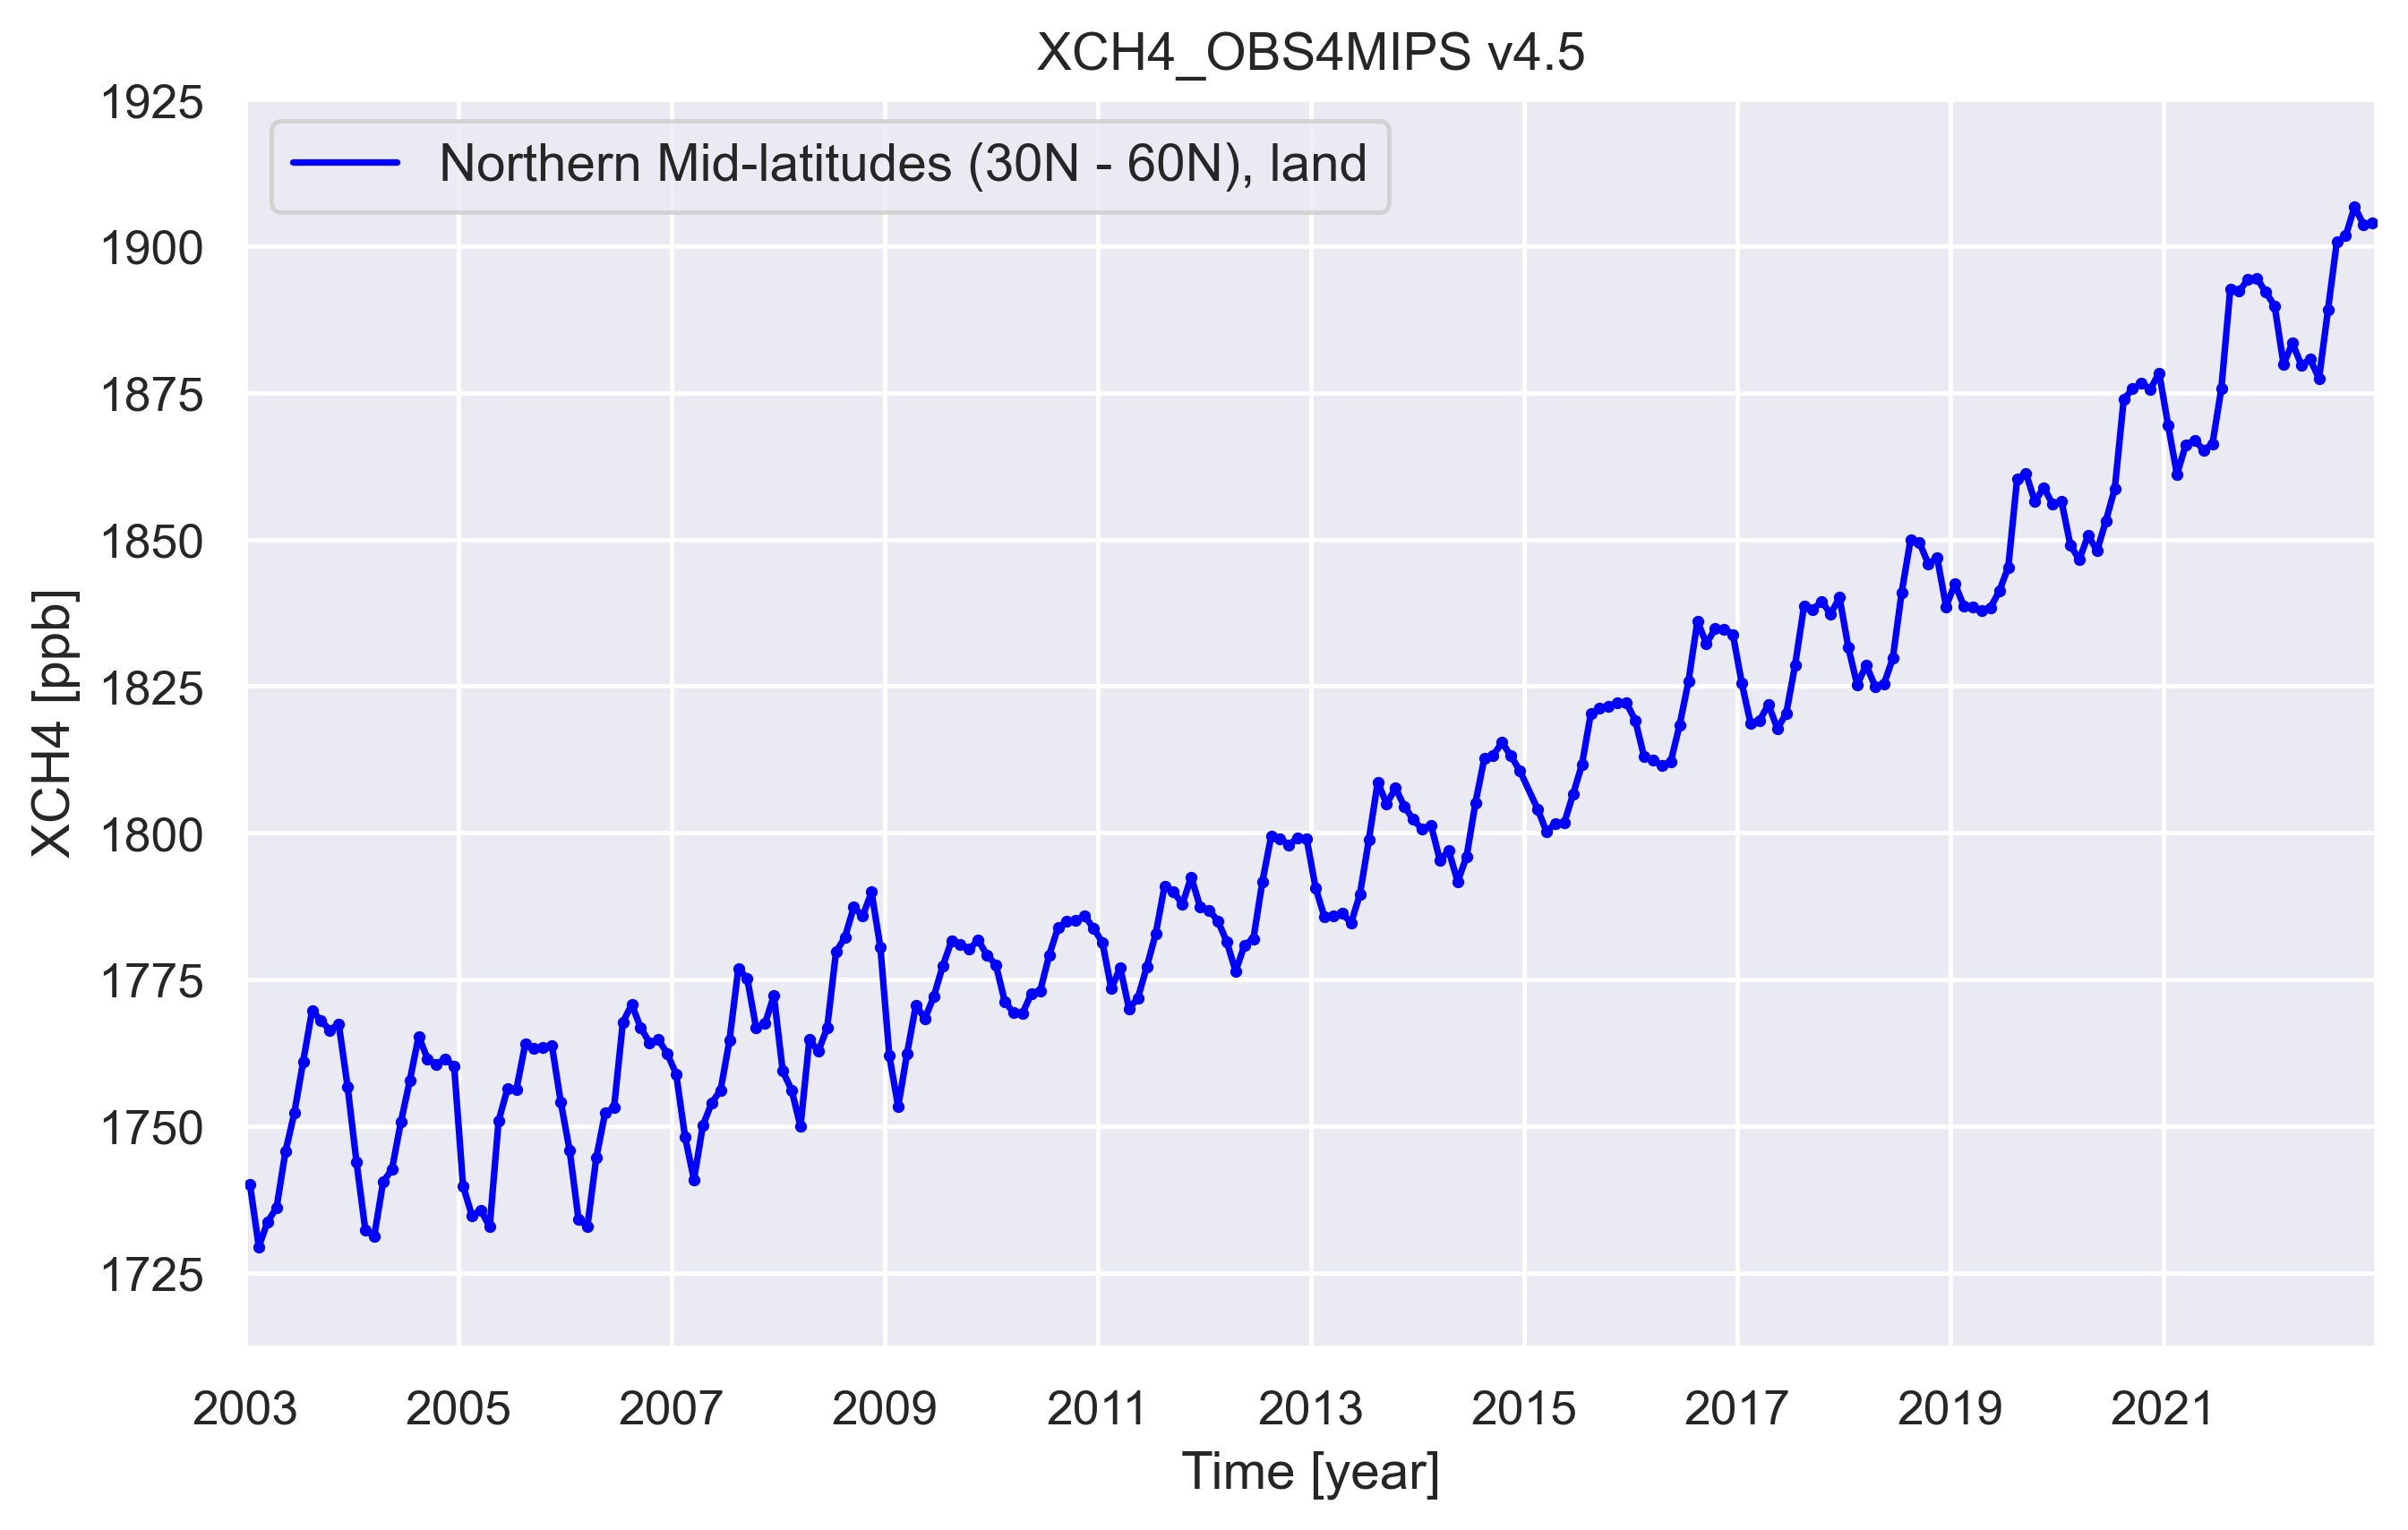

In [28]:
if wanted_file_OK == 'yes':
   # Plot time series:
   print('* plotting time series ...')
   sns.set()                             # select seaborn for plot style 
   figsize = (8,5)
   fig = plt.figure(figsize=figsize)     # page size
   pos = [0.12, 0.14, 0.85, 0.80]        # position (left,bottom,width,height) in page coord
   ax  = fig.add_axes(pos)
   ax.ticklabel_format(useOffset=False)  # prevent scientific notation axis numbering
   xmin = np.min(s_year)                 # x axis range and annotation
   xmax = np.max(s_year)+1
   xxx_int = np.arange(xmin, xmax, 2)
   xxx_ano = [str(x) for x in xxx_int]
   ax.set_xticks(xxx_int)
   #ax.set_xticklabels(xxx_ano, fontsize=12)
   ax.set_xticklabels(xxx_ano)
   rmin = np.min(s_gas)*0.99             # y axis range
   rmax = np.max(s_gas)*1.01
   title = product_id+' '+product_version_2
   xtitle = 'Time [year]'
   ytitle = product_name+' '+unit
   plt.scatter(s_fyear, s_gas, s=3, zorder=10, color='blue')
   plt.plot(s_fyear, s_gas, zorder=10, color='blue', label=lat_band_str)
   ymin = rmin; ymax = rmax
   plt.axis([xmin, xmax, ymin, ymax])
   plt.title(title, fontsize=12); plt.xlabel(xtitle); plt.ylabel(ytitle)
   plt.legend(loc='upper left', fontsize='medium')
   plot_type = 'png'
   if plot_type == 'png':
      o_file_plot = product_id+'_'+product_version+'_timeseries.png'
      print('* generating: ', o_file_plot)
      plt.savefig(o_file_plot, dpi=600)
   else:
      plt.show()
else:
    print('* ERROR: File does not exist !?')

What does this time series tells us?: As can be seen, XCH4 has a strong seasonal cycle with a maximum in the second half of each year over northern hemispheric mid-latitudes. This is mainly due to natural sources such as wetlands, where CH4 emissions are largest when temperatures are high. As can also be seen, XCH4 was (apart from seasonal fluctuations) relatively constant until about 2006. Since 2007 methane is increasing (increasing again as methane was also increasing for several decades until the late 1990th). Additional information on these satellite-derived XCH4 and XCO2 time series can be found in the Copernicus press release from January 2023, where an earlier version of this data sets have been used: "Copernicus: 2022 was a year of climate extremes, with record high temperatures and rising concentrations of greenhouse gases", see https://climate.copernicus.eu/copernicus-2022-was-year-climate-extremes-record-high-temperatures-and-rising-concentrations. Please have to look at that website to get additional information about the evolution of atmospheric CO2 and XCH using these satellite observations including links to relevant scientific publications.

# Application 2: Investigating spatial variations and coverage

Here the user can chose time (year and month) and spatial domain to generate plots of the spatial distribution of the selected GHG. 

* plotting map ...
* generating:  XCH4_OBS4MIPS_v4.5_map_main.png


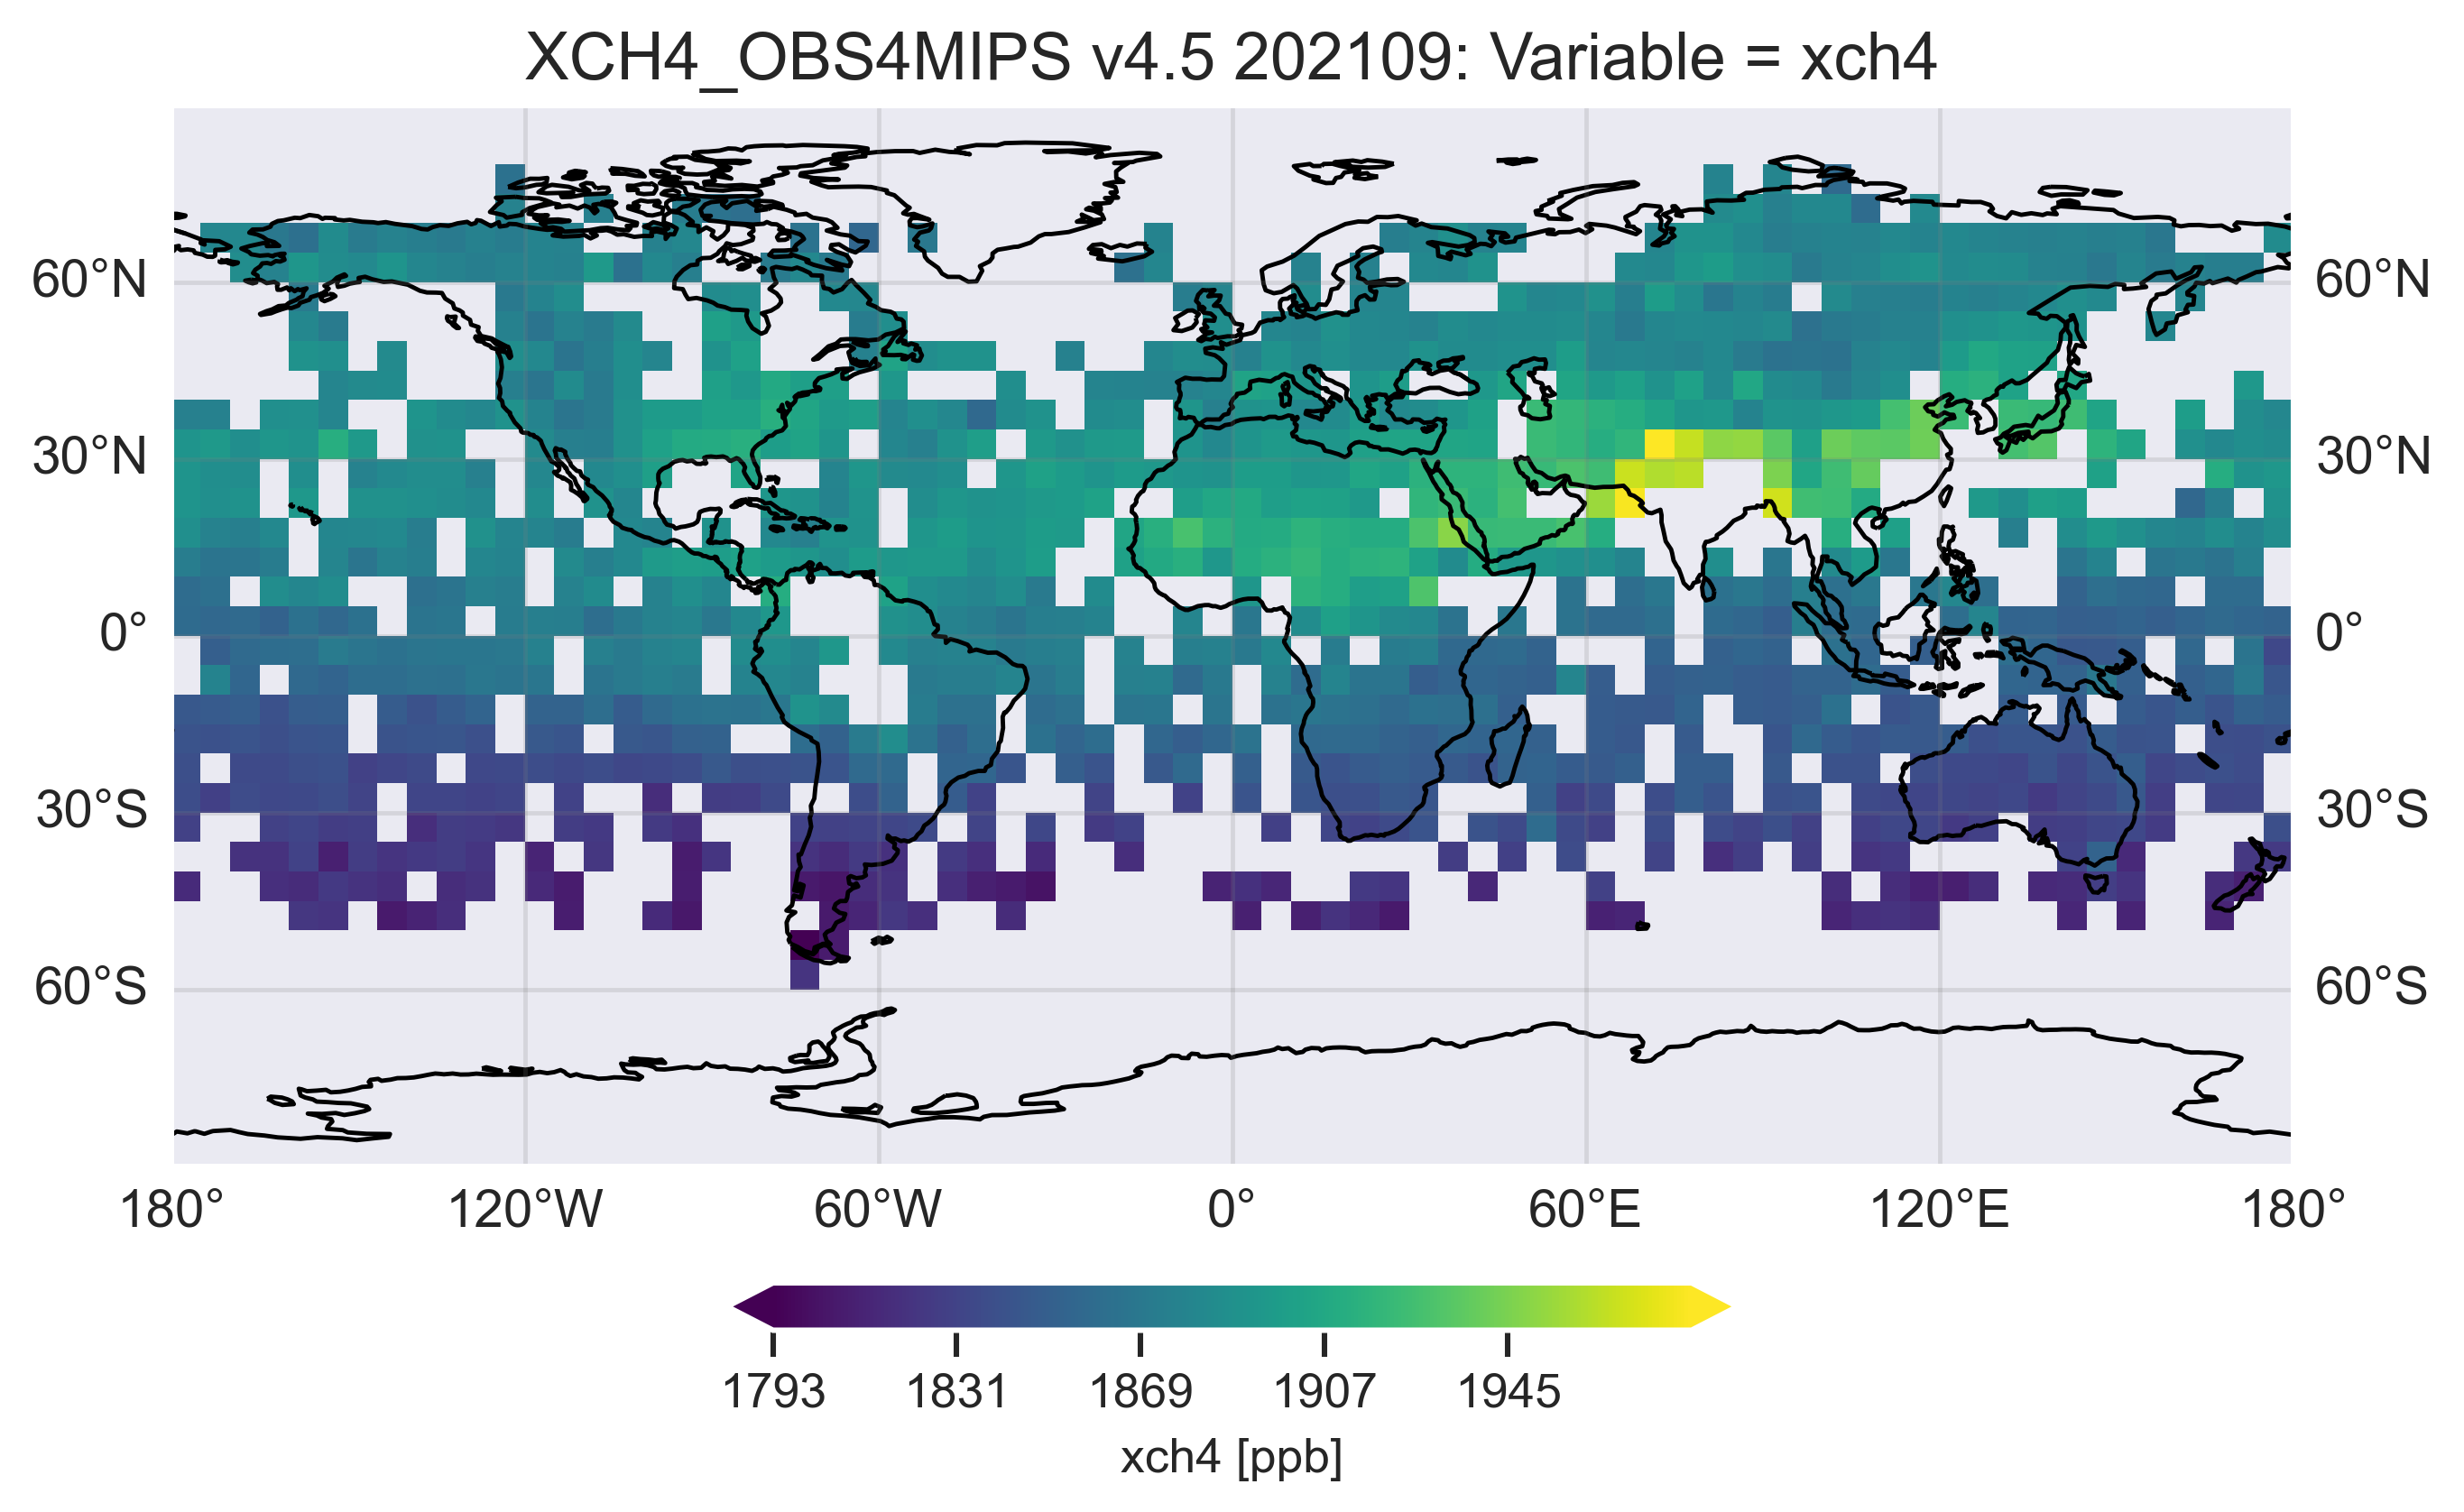

In [29]:
if wanted_file_OK == 'yes':
   print('* plotting map ...')
   
   # Select year and month:
   wanted_year  = '2021'
   wanted_month = '09'
   
   # Get (only) data for wanted month
   wanted_time = wanted_year+'-'+wanted_month
   da = ds.sel(time=wanted_time)
   n_time_da = da.dims['time']
   plot_map_OK = 'no'
   #print('* n_time_da (should be 1 (= 1 month) !?): ', n_time_da)
   if n_time_da != 1:
      print('* ERROR: n_time_da != 1: ', n_time_da)
   else:
      # Get lat, lon, data for plot
      coord_lat  = da.coords['lat'].values          # Get latitudes
      coord_lon  = da.coords['lon'].values          # Get longitudes
      data = da[wanted_variable]                    # Get xco2 or xch4
      act_time = data.time.values[0]                # Get time
      ts = pd.to_datetime(str(act_time))
      act_year  = ts.strftime('%Y')
      act_month = ts.strftime('%m')
      data = data.isel(time=0)                      # Remove time dimension
      data = data * unit_conv                       # conversion to ppm or ppb
      plt_data     = data.values                    # Get data values to be plotted
      plt_data_min = int(data.min().values)         # Get minimum data value for plot
      plt_data_max = int(data.max().values)         # Get maximum data value for plot
      plt_data_mean     = np.nanmean(plt_data)      # Compute mean value
      plt_data_std      = np.nanstd(plt_data)       # Compute standard deviation
      plt_data_mean_str = '{:.1f}'.format(plt_data_mean)
      plt_data_std_str  = '{:.1f}'.format(plt_data_std)
      plt_data_str      = 'mean+/-std: '+plt_data_mean_str+'+/-'+plt_data_std_str
      # ------------------
      plt_lat      = coord_lat    
      plt_lon      = coord_lon    
      sns.set()                                     # use seaborn plot style
      proj = ccrs.PlateCarree()
      latlon_bounds = [-180, 180, -90, 90]          # Set lat/lon range for plot
      figsize = (8,5)                               # Figure size
      # -------
      n_ticks = 5                                   # Set color bar parameters
      vmin  = plt_data_min
      vmax  = plt_data_max
      vinc  = (vmax-vmin) / n_ticks
      vinc  = int(np.ceil(vinc)) # next largest int
      vmax  = vmin + n_ticks * vinc
      # -------
      fig = plt.figure(figsize=figsize) # page size
      pos = [0.08, 0.22, 0.84, 0.72] # position (left,bottom,width,height) in page coordinates
      ax  = fig.add_axes(pos, projection=proj)
      cs = ax.pcolormesh(plt_lon, plt_lat, plt_data, shading='auto', cmap='viridis', transform=proj, vmin=vmin, vmax=vmax)
      ax.coastlines()
      drawmeridians_label = True
      gl = ax.gridlines(crs=proj, draw_labels=drawmeridians_label, linewidth=1, color='gray', alpha=0.2)
      gl.top_labels  = False
      tit = product_id+' '+product_version_2+' '+wanted_year+wanted_month+': Variable = '+wanted_variable
      ax.set_title(tit, fontsize=15)
      # color bar:
      cbar_ax        = fig.add_axes([0.3, 0.14, 0.4, 0.03]) # position
      cbar           = fig.colorbar(cs, cax=cbar_ax, ticks=np.arange(vmin, vmax, vinc), orientation='horizontal', extend='both')
      cbar_title     = wanted_variable+' '+unit
      cbar.set_label(cbar_title, rotation=0, fontsize=11, labelpad=5) # labepad->y-shift
      # ----------------------------------------
      plot_map_OK = 'yes'
      # ----------------------------------------
      plot_type = 'png'
      if plot_type == 'png':
         o_file_plot = product_id+'_'+product_version+'_map_main.png'
         print('* generating: ', o_file_plot)
         plt.savefig(o_file_plot, dpi=600)
      else:
         plt.show()

As can be seen, the spatial variation is typically small. The largest difference is often the interhemisheric difference, i.e., the concentration difference between the two hemispheres. Nevertheless, strong source regions may be visible via locally enhanced concentrations.

Here a second maps is generated to see the corresponding (1-sigma) uncertainty of the satellite observations, which is contained for each month and each grid cell in the data product.

* plotting 2nd map (uncertainty) ...
* generating:  XCH4_OBS4MIPS_v4.5_map_unc.png


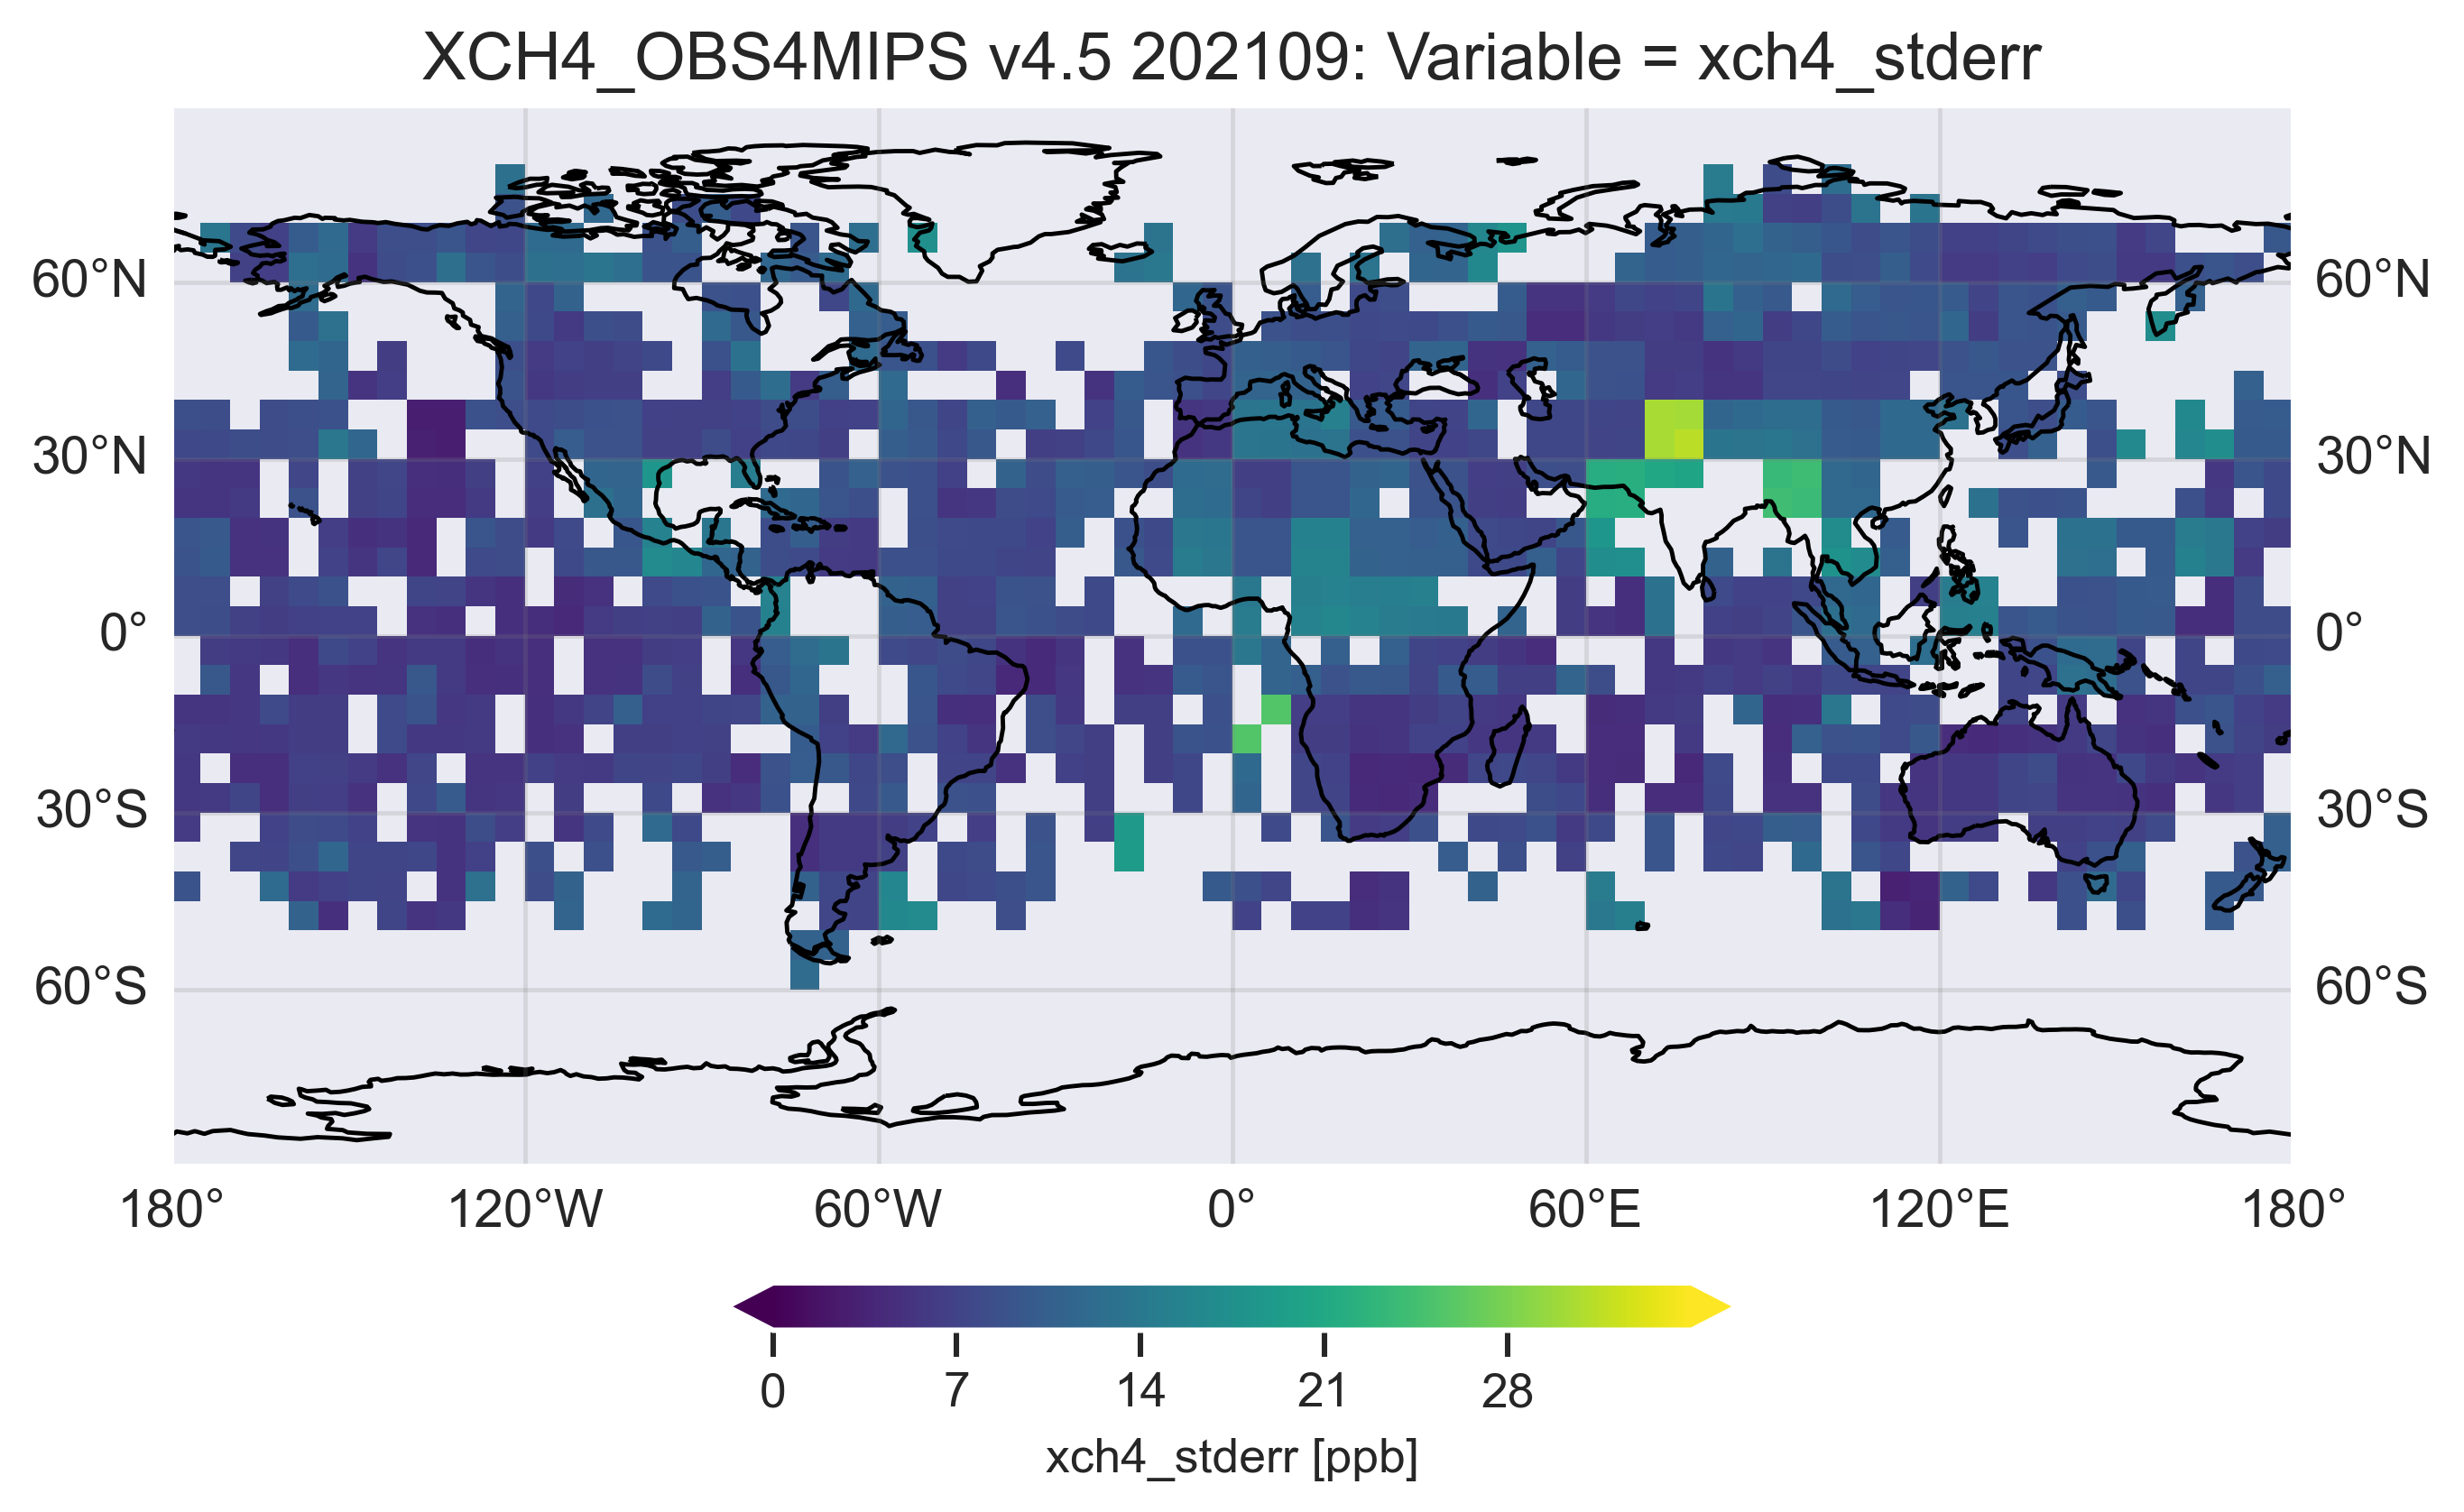

In [20]:
if wanted_file_OK == 'yes':
   print('* plotting 2nd map (uncertainty) ...')
   if plot_map_OK != 'yes':
      print('* ERROR: Cannot plot uncertainty map: plot_map_OK: ', plot_map_OK)
   else:
      data_unc = da[wanted_variable_unc]      # Get xco2 or xch4 uncertainty
      data_unc = data_unc.isel(time=0)        # Remove time dimension
      data_unc = data_unc * unit_conv         # conversion to ppm or ppb
      plt_data_unc     = data_unc.values  # 
      plt_data_unc_min = int(data_unc.min().values)
      plt_data_unc_max = int(data_unc.max().values)
      plt_data_unc_mean     = np.nanmean(plt_data_unc)
      plt_data_unc_std      = np.nanstd(plt_data_unc)
      plt_data_unc_mean_str = '{:.1f}'.format(plt_data_unc_mean)
      plt_data_unc_std_str  = '{:.1f}'.format(plt_data_unc_std)
      plt_data_unc_str      = 'mean+/-std: '+plt_data_unc_mean_str+'+/-'+plt_data_unc_std_str
      # ------------------
      # -------
      n_ticks = 5                            # Set color bar parameters
      vmin  = 0
      vmax  = plt_data_unc_max
      vinc  = (vmax-vmin) / n_ticks
      vinc  = int(np.ceil(vinc))             # next largest int
      vmax  = vmin + n_ticks * vinc
      # -------
      figsize = (8,5)                        # figure size
      pos = [0.08, 0.22, 0.84, 0.72]         # position (left,bottom,width,height) in page coordinates
      fig2 = plt.figure(figsize=figsize)     
      ax2  = fig2.add_axes(pos, projection=proj)
      cs = ax2.pcolormesh(plt_lon, plt_lat, plt_data_unc, shading='auto', cmap='viridis', transform=proj, vmin=vmin, vmax=vmax)
      ax2.coastlines()
      gl = ax2.gridlines(crs=proj, draw_labels=drawmeridians_label, linewidth=1, color='gray', alpha=0.2)
      gl.top_labels  = False
      tit = product_id+' '+product_version_2+' '+wanted_year+wanted_month+': Variable = '+wanted_variable_unc
      ax2.set_title(tit, fontsize=15)
      # color bar:
      cbar_ax        = fig2.add_axes([0.3, 0.14, 0.4, 0.03]) # position
      cbar           = fig2.colorbar(cs, cax=cbar_ax, ticks=np.arange(vmin, vmax, vinc), orientation='horizontal', extend='both')
      cbar_title     = wanted_variable_unc+' '+unit
      cbar.set_label(cbar_title, rotation=0, fontsize=11, labelpad=5) # labepad->y-shift
      # ----------------------------------------
      plot_type = 'png'
      if plot_type == 'png':
         o_file_plot = product_id+'_'+product_version+'_map_unc.png'
         print('* generating: ', o_file_plot)
         plt.savefig(o_file_plot, dpi=600)
      else:
         plt.show()

As can be seen, the uncertainty is similar for most regions. For XCH4 the uncertainty is typically on the order of 10 ppb, but may be as large a 20 or 30 ppb for some regions. These are mostly regions with sparse coverage (e.g. due to clouds) and/or a poorly reflecting surface.